In [1]:
import pandas as pd
import datetime as dt
from datetime import date, timedelta
import os
import openpyxl

In [2]:
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [4]:
# Библиотека openpyxl
wb = openpyxl.load_workbook('анализ_массовых_отключений_обновленная_форма.xlsx')

sheet = wb.active
sheet['A1'].value

'Федеральный округ'

# Загрузка данных

In [5]:
# Загружаем данные

df_main = pd.read_excel('анализ_массовых_отключений_обновленная_форма.xlsx')

In [6]:
# Проверяем размерности таблиц
df_main.shape

(676, 11)

In [7]:
df_main.columns = ['Федеральный_округ', '№ ', 'Субъект_РФ',
       'количество_cлучаев', 'Дата_время',
       'Количество_обесточенных_потребителей',
       'Мощность_обесточенных_потребителей', 'Количество_обесточенных_ТП',
       'Время_окончания_АВР', 'Длительность', 'Причина_аварий_(ОЯ)']

In [8]:
df_main.drop(['№ ','Причина_аварий_(ОЯ)'],axis=1, inplace=True)

In [9]:
df_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 676 entries, 0 to 675
Data columns (total 9 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   Федеральный_округ                     676 non-null    object        
 1   Субъект_РФ                            676 non-null    object        
 2   количество_cлучаев                    676 non-null    int64         
 3   Дата_время                            676 non-null    datetime64[ns]
 4   Количество_обесточенных_потребителей  676 non-null    int64         
 5   Мощность_обесточенных_потребителей    676 non-null    float64       
 6   Количество_обесточенных_ТП            676 non-null    int64         
 7   Время_окончания_АВР                   676 non-null    datetime64[ns]
 8   Длительность                          676 non-null    object        
dtypes: datetime64[ns](2), float64(1), int64(3), object(3)
memory usage: 47.7+ KB


# Очистка и обогащение

In [10]:
df_main['Год'] = df_main['Дата_время'].apply(lambda x: x.year)

df_main['Месяц'] = df_main['Дата_время'].apply(lambda x: x.month)

df_main['День'] = df_main['Дата_время'].apply(lambda x: x.day)

df_main['Длительность_часов'] = (df_main['Время_окончания_АВР'] - df_main['Дата_время'])

df_main['Длительность_часов'] = df_main['Длительность_часов'].apply(lambda x: (x.days*24 + x.seconds/3600))

df_main['Длительность_относительная'] = df_main['Длительность_часов']/df_main['Количество_обесточенных_потребителей']*1000

df_main['Субъект_РФ'] = df_main['Субъект_РФ'].apply(lambda x: x.strip())

df_main['ОЗП'] = df_main['Месяц'].apply(lambda x: 1 if 11 <=x or x<=3 else 0)

In [11]:
df_main['ОЗП_сезон'] = None

# Пропишем сезоны для ОЗП

for i in df_main.index:
    if 1<= df_main.loc[i]['Месяц'] <= 3:
        df_main.at[i,'ОЗП_сезон'] = f"{df_main.loc[i]['Год']-1}/{df_main.loc[i]['Год']}"
        #loc[i]['ОЗП_сезон'] = str(f"{df_main.loc[i]['Год']-1}/{df_main.loc[i]['Год']}")
    elif 11<= df_main.loc[i]['Месяц'] <= 12:
        df_main.at[i,'ОЗП_сезон'] = f"{df_main.loc[i]['Год']}/{df_main.loc[i]['Год']+1}"
        #df_main.loc[i]['ОЗП_сезон'] = str(f"{df_main.loc[i]['Год']}/{df_main.loc[i]['Год']+1}")
    else:
        df_main.loc[i]['ОЗП_сезон'] = 0

In [12]:
# Загрузим датафрейм с данными по населению по регионам
pop = pd.read_csv('population')
pop.columns = ['Субъект_РФ','население']

# Присоединим данные по населению к общему датафрейму
df = df_main.copy()
df = df.merge(pop, on = 'Субъект_РФ', how = 'left')

df['население'] = df['население'].apply(lambda x: int(x))

In [13]:
# Датафрейм для конкатинации заголовков
test_col2 = pd.DataFrame({0:['Федеральный_округ','Года']})

Year = 2013
for i in range(1,df['Год'].nunique()+1):
    test_col2[i] = [0, Year]
    i =+1
    Year +=1

In [14]:
# Датафрейм для конкатинации заголовков
test_col3 = pd.DataFrame({0:['Федеральный_округ','Года']})

Year = 2013
for i in range(1,df['Год'].nunique()+1):
    test_col3[i] = [0, f"{Year-1}/{Year}"]
    i =+1
    Year +=1

In [15]:
df_main[(df_main['ОЗП_сезон']=='2017/2018')&(df_main['Месяц'].isin([1,2,11,12]))].sum()
#df_main[df_main['Год']==2020]

Федеральный_округ                       ЮФОЦФОЦФОЦФОЮФОЦФОЦФОЦФОСФОСФОСЗФОЦФОСЗФОПФОПФ...
Субъект_РФ                              Астраханская областьБрянская областьВладимирск...
количество_cлучаев                                                                     32
Количество_обесточенных_потребителей                                               472250
Мощность_обесточенных_потребителей                                                 388.82
Количество_обесточенных_ТП                                                          10006
Год                                                                                 64558
Месяц                                                                                 234
День                                                                                  432
Длительность_часов                                                                650.083
Длительность_относительная                                                        63.5623
ОЗП       

In [16]:
df_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 676 entries, 0 to 675
Data columns (total 16 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   Федеральный_округ                     676 non-null    object        
 1   Субъект_РФ                            676 non-null    object        
 2   количество_cлучаев                    676 non-null    int64         
 3   Дата_время                            676 non-null    datetime64[ns]
 4   Количество_обесточенных_потребителей  676 non-null    int64         
 5   Мощность_обесточенных_потребителей    676 non-null    float64       
 6   Количество_обесточенных_ТП            676 non-null    int64         
 7   Время_окончания_АВР                   676 non-null    datetime64[ns]
 8   Длительность                          676 non-null    object        
 9   Год                                   676 non-null    int64         
 10  Ме

In [17]:
df_main[df_main['Год']==2021].groupby('Субъект_РФ')['Длительность_часов'].mean()
target_list = list(df_main[df_main['Год']==2021].groupby('Субъект_РФ')['Длительность_часов'].mean().index)

In [18]:
df_main[(df_main['Год']==2020)&
       df_main['Месяц'].isin([1,2])].groupby('Субъект_РФ')['Длительность_часов'].sum()

Субъект_РФ
Воронежская область     10.500000
Республика Дагестан     43.716667
Ростовская область      10.866667
Чеченская Республика     6.583333
Name: Длительность_часов, dtype: float64

In [19]:
df_main.columns

Index(['Федеральный_округ', 'Субъект_РФ', 'количество_cлучаев', 'Дата_время',
       'Количество_обесточенных_потребителей',
       'Мощность_обесточенных_потребителей', 'Количество_обесточенных_ТП',
       'Время_окончания_АВР', 'Длительность', 'Год', 'Месяц', 'День',
       'Длительность_часов', 'Длительность_относительная', 'ОЗП', 'ОЗП_сезон'],
      dtype='object')

In [42]:
df_main[(df_main['Год']==2020)&(df_main['Субъект_РФ']=='Республика Дагестан')]['Мощность_обесточенных_потребителей'].mean()

34.79

In [99]:
df_OZP_1920 = df_main[df_main['ОЗП_сезон']=='2019/2020']
df_OZP_1920_short = df_OZP_1920.iloc[:-5]
df_OZP_2021 = df_main[df_main['ОЗП_сезон']=='2020/2021']
#.sort_values(by=['Длительность_часов'],ascending=False)
#df_main[df_main['Год']==2020]['Длительность_часов'].mean()

##### Функция перепила таблицы

In [100]:
def make_df(df):
    ## Количество случаев

    df_count_acc = pd.DataFrame()

    for FO in df['Федеральный_округ'].unique():
        df_transit1 = pd.DataFrame(
            df[df['Федеральный_округ']==FO].groupby('Год')['количество_cлучаев'].count()).T
        df_transit1.index = [FO]
        df_count_acc= pd.concat([df_count_acc, df_transit1])
        for region in df[df['Федеральный_округ']==FO]['Субъект_РФ'].unique():
            df_transit2 = pd.DataFrame(
                df[df['Субъект_РФ']== region].groupby('Год')['количество_cлучаев'].count()).T
            df_transit2.index = [region]
            df_count_acc = pd.concat([df_count_acc, df_transit2])

    df_count_acc = df_count_acc.fillna(0)

    # Приведем ДФ к нужному виду
    df_count_acc = df_count_acc.reset_index()

    df_count_acc.columns = list(range(df_count_acc.shape[1]))

    df_count_acc = pd.concat([test_col2.reset_index(drop=True),df_count_acc.reset_index(drop=True)],axis=0)

    ## Количество отключенных потребителей

    df_consum = pd.DataFrame()

    for FO in df['Федеральный_округ'].unique():
        df_transit1 = pd.DataFrame(
            df[df['Федеральный_округ']==FO].groupby('Год')['Количество_обесточенных_потребителей'].sum()).T
        df_transit1.index = [FO]
        df_consum= pd.concat([df_consum, df_transit1])
        for region in df[df['Федеральный_округ']==FO]['Субъект_РФ'].unique():
            df_transit2 = pd.DataFrame(
                df[df['Субъект_РФ']== region].groupby('Год')['Количество_обесточенных_потребителей'].sum()).T
            df_transit2.index = [region]
            df_consum = pd.concat([df_consum, df_transit2])

    df_consum = df_consum.fillna(0)

    # Приведем ДФ к нужному виду
    df_consum = df_consum.reset_index()

    df_consum.columns = list(range(df_consum.shape[1]))

    df_consum = pd.concat([test_col2.reset_index(drop=True),df_consum.reset_index(drop=True)],axis=0)

    ## Мощность отключенных потребителей

    df_power = pd.DataFrame()

    for FO in df['Федеральный_округ'].unique():
        df_transit1 = pd.DataFrame(
            df[df['Федеральный_округ']==FO].groupby('Год')['Мощность_обесточенных_потребителей'].sum()).T
        df_transit1.index = [FO]
        df_power= pd.concat([df_power, df_transit1])
        for region in df[df['Федеральный_округ']==FO]['Субъект_РФ'].unique():
            df_transit2 = pd.DataFrame(
                df[df['Субъект_РФ']== region].groupby('Год')['Мощность_обесточенных_потребителей'].sum()).T
            df_transit2.index = [region]
            df_power = pd.concat([df_power, df_transit2])

    df_power = df_power.fillna(0)

    # Приведем ДФ к нужному виду
    df_power = df_power.reset_index()

    df_power.columns = list(range(df_power.shape[1]))

    df_power = pd.concat([test_col2.reset_index(drop=True),df_power.reset_index(drop=True)],axis=0)

    ## Общее вермя устранения аварии

    df_total_time = pd.DataFrame()

    for FO in df['Федеральный_округ'].unique():
        df_transit1 = pd.DataFrame(
            df[df['Федеральный_округ']==FO].groupby('Год')['Длительность_часов'].sum()).T
        df_transit1.index = [FO]
        df_total_time= pd.concat([df_total_time, df_transit1])
        for region in df[df['Федеральный_округ']==FO]['Субъект_РФ'].unique():
            df_transit2 = pd.DataFrame(
                df[df['Субъект_РФ']== region].groupby('Год')['Длительность_часов'].sum()).T
            df_transit2.index = [region]
            df_total_time = pd.concat([df_total_time, df_transit2])

    df_total_time = df_total_time.fillna(0)
    df_total_time = df_total_time.round(2)

    # Приведем ДФ к нужному виду
    df_total_time = df_total_time.reset_index()

    df_total_time.columns = list(range(df_total_time.shape[1]))

    df_total_time = pd.concat([test_col2.reset_index(drop=True),df_total_time.reset_index(drop=True)],axis=0)

    ## Среднее время устранения аварии

    df_mean_time = pd.DataFrame()

    for FO in df['Федеральный_округ'].unique():
        df_transit1 = pd.DataFrame(
            df[df['Федеральный_округ']==FO].groupby('Год')['Длительность_часов'].mean()).T
        df_transit1.index = [FO]
        df_mean_time= pd.concat([df_mean_time, df_transit1])
        for region in df[df['Федеральный_округ']==FO]['Субъект_РФ'].unique():
            df_transit2 = pd.DataFrame(
                df[df['Субъект_РФ']== region].groupby('Год')['Длительность_часов'].mean()).T
            df_transit2.index = [region]
            df_mean_time = pd.concat([df_mean_time, df_transit2])

    df_mean_time = df_mean_time.fillna(0)
    df_mean_time = df_mean_time.round(2)

    # Приведем ДФ к нужному виду
    df_mean_time = df_mean_time.reset_index()

    df_mean_time.columns = list(range(df_mean_time.shape[1]))

    df_mean_time = pd.concat([test_col2.reset_index(drop=True),df_mean_time.reset_index(drop=True)],axis=0)

    # Свод таблиц

    df_target = pd.concat([df_count_acc,df_consum.drop(0, axis=1)],axis=1)
    df_target = pd.concat([df_target,df_power.drop(0, axis=1)],axis=1)
    df_target = pd.concat([df_target,df_total_time.drop(0, axis=1)],axis=1)
    df_target = pd.concat([df_target,df_mean_time.drop(0, axis=1)],axis=1)

    df_target.reset_index(drop=True, inplace=True)
    return df_target

# Функция перепила для ОЗП

In [101]:
def make_df_OZP(df):
    ## Количество случаев

    df_count_acc = pd.DataFrame()

    for FO in df['Федеральный_округ'].unique():
        df_transit1 = pd.DataFrame(
            df[df['Федеральный_округ']==FO].groupby('ОЗП_сезон')['количество_cлучаев'].count()).T
        df_transit1.index = [FO]
        df_count_acc= pd.concat([df_count_acc, df_transit1])
        for region in df[df['Федеральный_округ']==FO]['Субъект_РФ'].unique():
            df_transit2 = pd.DataFrame(
                df[df['Субъект_РФ']== region].groupby('ОЗП_сезон')['количество_cлучаев'].count()).T
            df_transit2.index = [region]
            df_count_acc = pd.concat([df_count_acc, df_transit2])
    
    df_count_acc = df_count_acc[['2012/2013', '2013/2014', '2014/2015','2015/2016','2016/2017', '2017/2018','2018/2019', '2019/2020', '2020/2021']]    
    df_count_acc = df_count_acc.fillna(0)

    # Приведем ДФ к нужному виду
    df_count_acc = df_count_acc.reset_index()

    df_count_acc.columns = list(range(df_count_acc.shape[1]))

    df_count_acc = pd.concat([test_col3.reset_index(drop=True),df_count_acc.reset_index(drop=True)],axis=0)

    ## Количество отключенных потребителей

    df_consum = pd.DataFrame()

    for FO in df['Федеральный_округ'].unique():
        df_transit1 = pd.DataFrame(
            df[df['Федеральный_округ']==FO].groupby('ОЗП_сезон')['Количество_обесточенных_потребителей'].sum()).T
        df_transit1.index = [FO]
        df_consum= pd.concat([df_consum, df_transit1])
        for region in df[df['Федеральный_округ']==FO]['Субъект_РФ'].unique():
            df_transit2 = pd.DataFrame(
                df[df['Субъект_РФ']== region].groupby('ОЗП_сезон')['Количество_обесточенных_потребителей'].sum()).T
            df_transit2.index = [region]
            df_consum = pd.concat([df_consum, df_transit2])
    
    df_consum = df_consum[['2012/2013', '2013/2014', '2014/2015','2015/2016','2016/2017', '2017/2018','2018/2019', '2019/2020', '2020/2021']]    
    df_consum = df_consum.fillna(0)

    # Приведем ДФ к нужному виду
    df_consum = df_consum.reset_index()

    df_consum.columns = list(range(df_consum.shape[1]))

    df_consum = pd.concat([test_col3.reset_index(drop=True),df_consum.reset_index(drop=True)],axis=0)

    ## Мощность отключенных потребителей

    df_power = pd.DataFrame()

    for FO in df['Федеральный_округ'].unique():
        df_transit1 = pd.DataFrame(
            df[df['Федеральный_округ']==FO].groupby('ОЗП_сезон')['Мощность_обесточенных_потребителей'].sum()).T
        df_transit1.index = [FO]
        df_power= pd.concat([df_power, df_transit1])
        for region in df[df['Федеральный_округ']==FO]['Субъект_РФ'].unique():
            df_transit2 = pd.DataFrame(
                df[df['Субъект_РФ']== region].groupby('ОЗП_сезон')['Мощность_обесточенных_потребителей'].sum()).T
            df_transit2.index = [region]
            df_power = pd.concat([df_power, df_transit2])
    
    df_power = df_power[['2012/2013', '2013/2014', '2014/2015','2015/2016','2016/2017', '2017/2018','2018/2019', '2019/2020', '2020/2021']]    
    df_power = df_power.fillna(0)

    # Приведем ДФ к нужному виду
    df_power = df_power.reset_index()

    df_power.columns = list(range(df_power.shape[1]))

    df_power = pd.concat([test_col3.reset_index(drop=True),df_power.reset_index(drop=True)],axis=0)

    ## Общее вермя устранения аварии

    df_total_time = pd.DataFrame()

    for FO in df['Федеральный_округ'].unique():
        df_transit1 = pd.DataFrame(
            df[df['Федеральный_округ']==FO].groupby('ОЗП_сезон')['Длительность_часов'].sum()).T
        df_transit1.index = [FO]
        df_total_time= pd.concat([df_total_time, df_transit1])
        for region in df[df['Федеральный_округ']==FO]['Субъект_РФ'].unique():
            df_transit2 = pd.DataFrame(
                df[df['Субъект_РФ']== region].groupby('ОЗП_сезон')['Длительность_часов'].sum()).T
            df_transit2.index = [region]
            df_total_time = pd.concat([df_total_time, df_transit2])
    
    df_total_time = df_total_time[['2012/2013', '2013/2014', '2014/2015','2015/2016','2016/2017', '2017/2018','2018/2019', '2019/2020', '2020/2021']]    
    df_total_time = df_total_time.fillna(0)
    df_total_time = df_total_time.round(2)

    # Приведем ДФ к нужному виду
    df_total_time = df_total_time.reset_index()

    df_total_time.columns = list(range(df_total_time.shape[1]))

    df_total_time = pd.concat([test_col3.reset_index(drop=True),df_total_time.reset_index(drop=True)],axis=0)

    ## Среднее время устранения аварии

    df_mean_time = pd.DataFrame()

    for FO in df['Федеральный_округ'].unique():
        df_transit1 = pd.DataFrame(
            df[df['Федеральный_округ']==FO].groupby('ОЗП_сезон')['Длительность_часов'].mean()).T
        df_transit1.index = [FO]
        df_mean_time= pd.concat([df_mean_time, df_transit1])
        for region in df[df['Федеральный_округ']==FO]['Субъект_РФ'].unique():
            df_transit2 = pd.DataFrame(
                df[df['Субъект_РФ']== region].groupby('ОЗП_сезон')['Длительность_часов'].mean()).T
            df_transit2.index = [region]
            df_mean_time = pd.concat([df_mean_time, df_transit2])

    df_mean_time = df_mean_time[['2012/2013', '2013/2014', '2014/2015','2015/2016','2016/2017', '2017/2018','2018/2019', '2019/2020', '2020/2021']]    
    df_mean_time = df_mean_time.fillna(0)
    df_mean_time = df_mean_time.round(2)

    # Приведем ДФ к нужному виду
    df_mean_time = df_mean_time.reset_index()

    df_mean_time.columns = list(range(df_mean_time.shape[1]))

    df_mean_time = pd.concat([test_col3.reset_index(drop=True),df_mean_time.reset_index(drop=True)],axis=0)

    # Свод таблиц

    df_target = pd.concat([df_count_acc,df_consum.drop(0, axis=1)],axis=1)
    df_target = pd.concat([df_target,df_power.drop(0, axis=1)],axis=1)
    df_target = pd.concat([df_target,df_total_time.drop(0, axis=1)],axis=1)
    df_target = pd.concat([df_target,df_mean_time.drop(0, axis=1)],axis=1)

    df_target.reset_index(drop=True, inplace=True)
    return df_target

# Таблицы по разным временным периодам

In [102]:
df_years = make_df(df)

df_ozp = make_df_OZP(df[df['ОЗП']==1])

df_6 = make_df(df[df['Месяц'] <= 6])

df_8 = make_df(df[df['Месяц'] <= 8])

# Создаем таблицу эксель

In [103]:
from openpyxl import Workbook
from openpyxl.utils.dataframe import dataframe_to_rows
wb = Workbook()

In [105]:
# прописываем номера колонок для объединения ячеек
start_column_1 = 2
start_column_2 = start_column_1 + df['Год'].nunique()
start_column_3 = start_column_2 + df['Год'].nunique()
start_column_4 = start_column_3 + df['Год'].nunique()
start_column_5 = start_column_4 + df['Год'].nunique()
start_column_6 = start_column_5 + df['Год'].nunique()

def make_excel2(df, name): 
    
    ws_target = wb.create_sheet(title=name)

    for r in dataframe_to_rows(df, index=False, header=False):
        ws_target.append(r)

    ws_target.column_dimensions['A'].width = 30
    ws_target.row_dimensions[1].height = 25
    ws_target.row_dimensions[2].height = 20

    ws_target.merge_cells(start_row=1, start_column=start_column_1, end_row=1, end_column=start_column_2-1)
    ws_target.cell(row = 1, column = start_column_1).value = 'Кол-во массовых нарушений'

    ws_target.merge_cells(start_row=1, start_column=start_column_2, end_row=1, end_column=start_column_3-1)
    ws_target.cell(row = 1, column = start_column_2).value = 'Кол-во отключенных потребителей, чел.'

    ws_target.merge_cells(start_row=1, start_column=start_column_3, end_row=1, end_column=start_column_4-1)
    ws_target.cell(row = 1, column = start_column_3).value = 'Мощность отключенных потребителей, МВт'

    ws_target.merge_cells(start_row=1, start_column=start_column_4, end_row=1, end_column=start_column_5-1)
    ws_target.cell(row = 1, column = start_column_4).value = 'Общее время устранения аварии, час.'

    ws_target.merge_cells(start_row=1, start_column=start_column_5, end_row=1, end_column=start_column_6-1)
    ws_target.cell(row = 1, column = start_column_5).value = 'Среднее время устранения аварии, час.'

In [106]:
make_excel2(df_years, 'По годам')
make_excel2(df_ozp, 'ОЗП')
make_excel2(df_6, 'За 6 месяцев')
make_excel2(df_8, 'За 8 месяцев')

In [107]:
std=wb.get_sheet_by_name('Sheet')
wb.remove_sheet(std)

In [108]:
wb.save('Массовые_новая_форма.xlsx')

# Общий анализ 

In [66]:
df.head(3)

,Федеральный_округ,Субъект_РФ,количество_cлучаев,Дата_время,Количество_обесточенных_потребителей,Мощность_обесточенных_потребителей,Количество_обесточенных_ТП,Время_окончания_АВР,Длительность,Год,Месяц,День,Длительность_часов,Длительность_относительная,ОЗП,ОЗП_сезон,население
0,СФО,Алтайский край,1,2014-05-13 16:00:00,10600,2.8,193,2014-05-14 04:00:00,12:00:00,2014,5,13,12.000000,1.132075,0,None,2317052
1,СФО,Алтайский край,1,2014-06-26 05:32:00,9800,3.5,188,2014-06-26 16:25:00,10:53:00,2014,6,26,10.883333,1.110544,0,None,2317052
2,СФО,Алтайский край,1,2014-05-24 12:57:00,15900,5.6,314,2014-05-25 02:40:00,13:43:00,2014,5,24,13.716667,0.862683,0,None,2317052


In [67]:
df['Проц_обесточ'] = df['Количество_обесточенных_потребителей']/ df['население']*100

In [68]:
df['длит_на_чел'] = df['Длительность_часов'] / df['Количество_обесточенных_потребителей']*1000

In [69]:
df['Недоотпуск'] = df['Мощность_обесточенных_потребителей']*df['Длительность_часов']

## 2020 год

In [32]:
df_reg_20 = pd.DataFrame()

df_reg_20['количество_cлучаев'] = df[df['Год']==2020].groupby('Субъект_РФ')['количество_cлучаев'].count()

df_reg_20['Сумм_обесточ'] = df[df['Год']==2020].groupby('Субъект_РФ')['Количество_обесточенных_потребителей'].sum()

df_reg_20['Сред_проц_обесточ'] = df[df['Год']==2020].groupby('Субъект_РФ')['Проц_обесточ'].mean()

df_reg_20['Сред_длит_на_чел'] = df[df['Год']==2020].groupby('Субъект_РФ')['длит_на_чел'].mean()

df_reg_20['Сумм_мощн_обесточ']  = df[df['Год']==2020].groupby('Субъект_РФ')['Мощность_обесточенных_потребителей'].sum()

In [33]:
#df_reg_20.to_excel('Анализ_масс_по_регионам_2020.xlsx')

In [34]:
df_reg_20.head(3)

,количество_cлучаев,Сумм_обесточ,Сред_проц_обесточ,Сред_длит_на_чел,Сумм_мощн_обесточ
Субъект_РФ,,,,,
Воронежская область,1,12100,0.520731,0.867769,8.30
Иркутская область,2,20700,0.432905,9.970442,12.24
Курганская область,1,18300,2.212975,2.638434,21.90


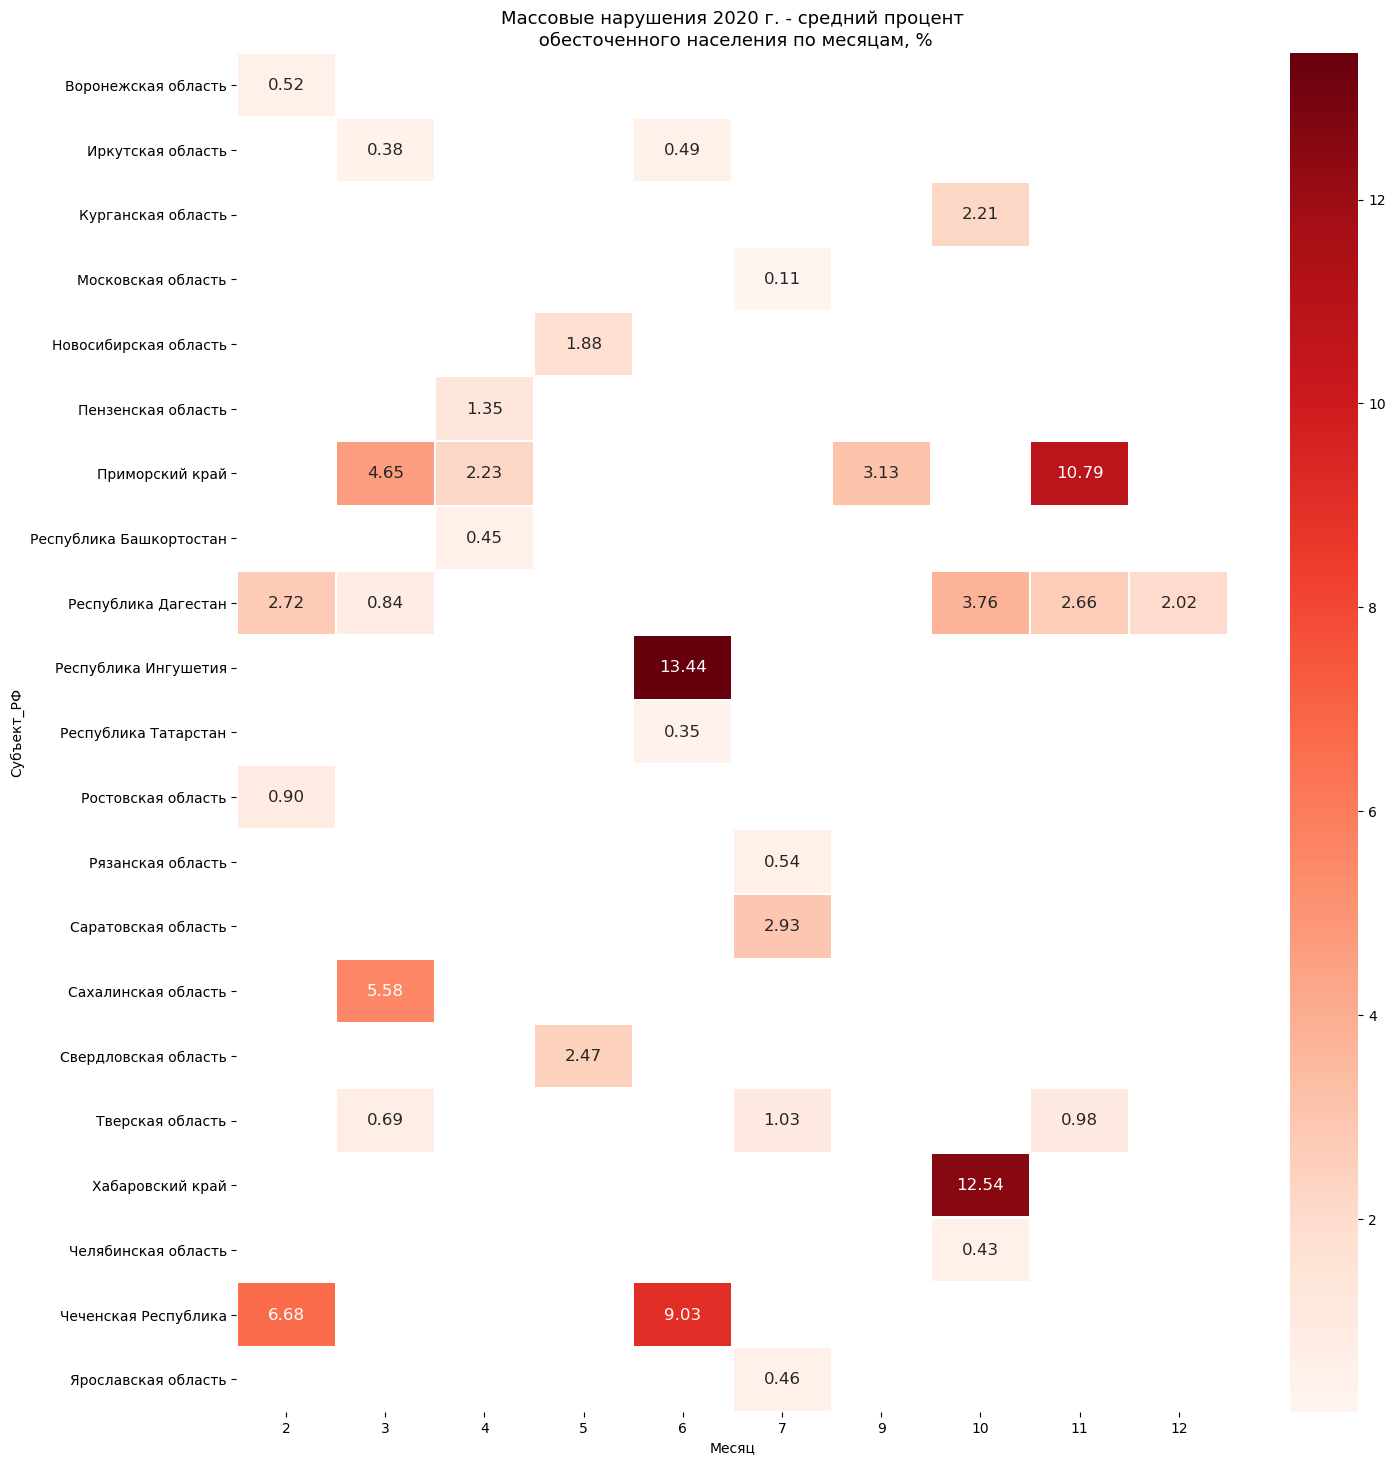

In [35]:
fig_h1 = plt.figure(figsize=(16,18), dpi= 100)
#sns.set(rc={'figure.figsize':(16,56)})

ax_h1 = fig_h1.add_subplot(1, 1, 1)

sns.heatmap(df[df['Год']==2020].pivot_table(
    index='Субъект_РФ', 
    columns='Месяц', 
    values='Проц_обесточ', 
    aggfunc='mean'), 
            annot=True, fmt='.2f', annot_kws={'fontsize':12}, cmap='Reds', linewidths=1, ax=ax_h1)



ax_h1.set_title(f'Массовые нарушения 2020 г. - средний процент\n обесточенного населения по месяцам, %',fontsize=13)

# fig_h1.set_figwidth(10)
# fig_h1.set_figheight(25)
#fig_h1.savefig(f'Масс_2020_Процент_обесточенного_населения')
plt.show()

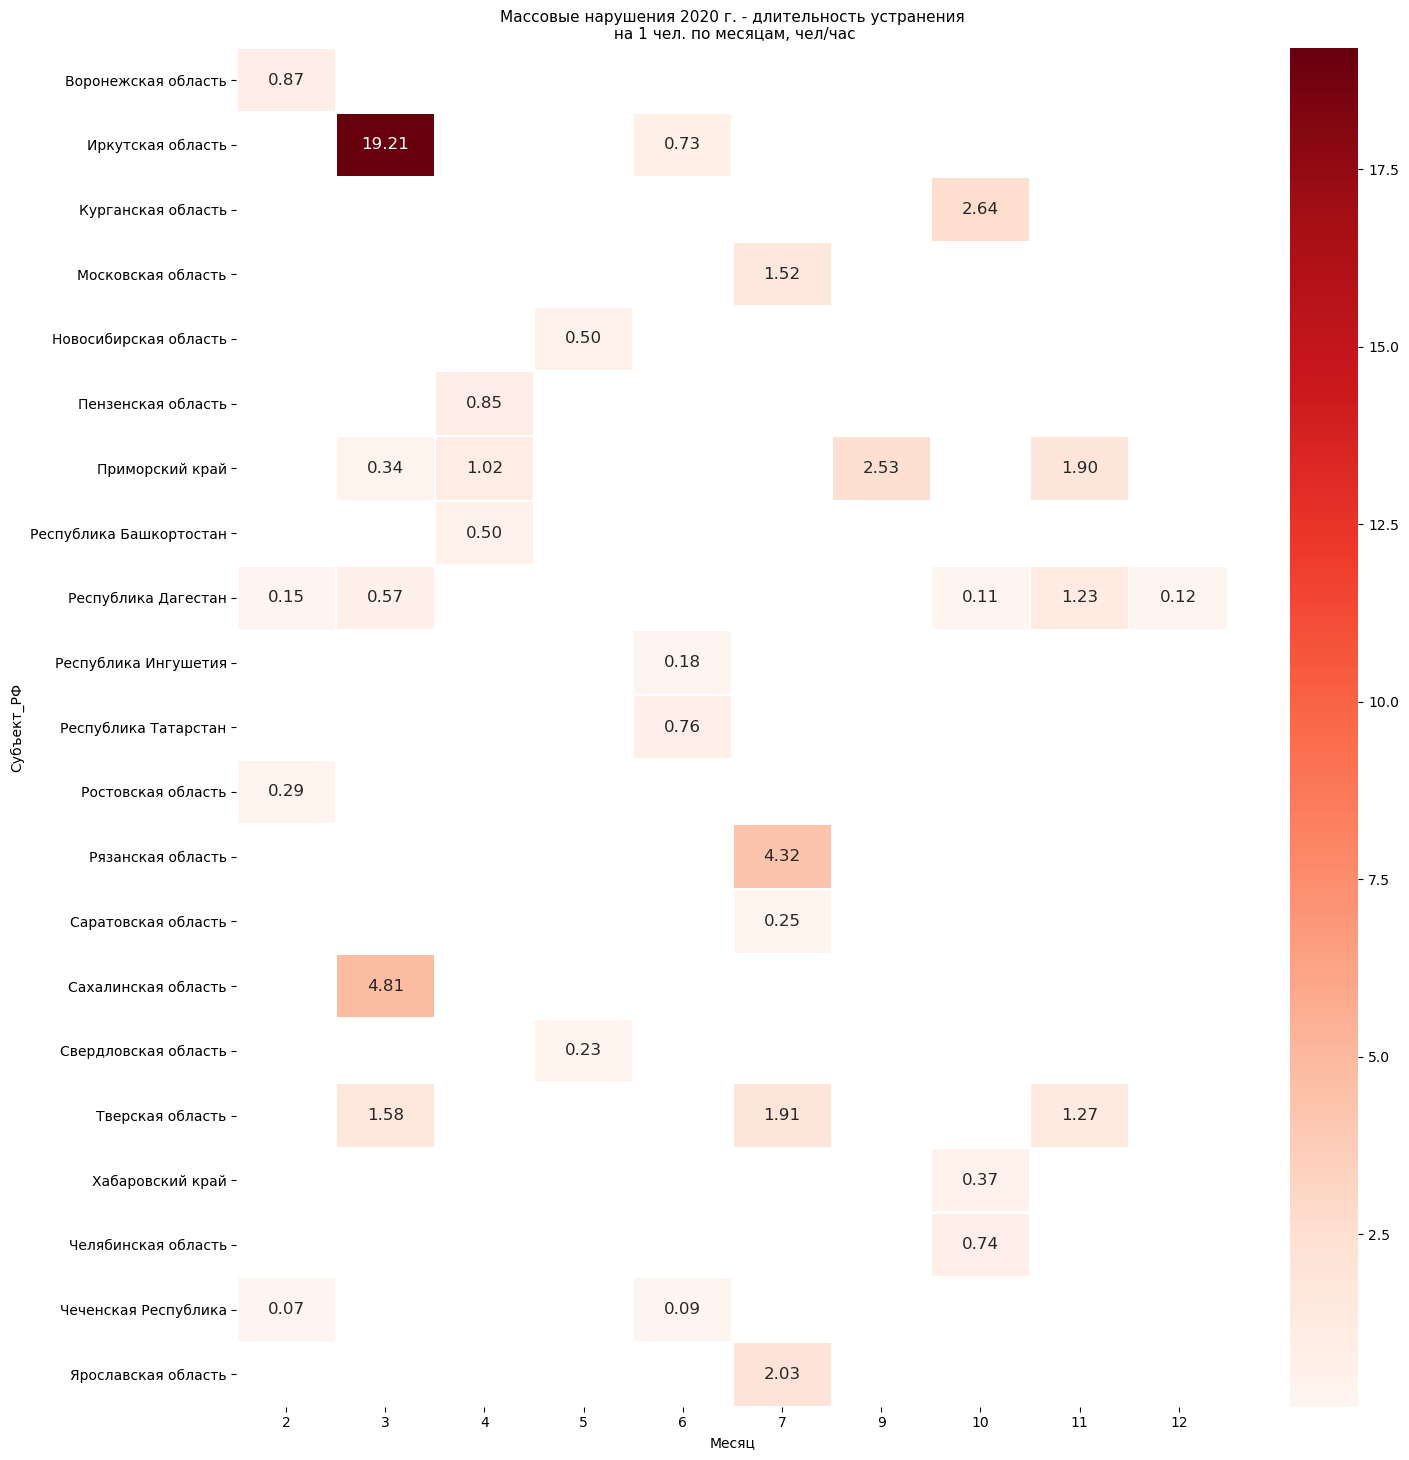

In [36]:
fig_h2 = plt.figure(figsize=(16,18), dpi= 100)
#sns.set(rc={'figure.figsize':(16,56)})

ax_h2 = fig_h2.add_subplot(1, 1, 1)

sns.heatmap(df[df['Год']==2020].pivot_table(
    index='Субъект_РФ', 
    columns='Месяц', 
    values='длит_на_чел', 
    aggfunc='mean'), 
            annot=True, fmt='.2f', annot_kws={'fontsize':12}, cmap='Reds', linewidths=1, ax=ax_h2)



ax_h2.set_title(f'Массовые нарушения 2020 г. - длительность устранения\n на 1 чел. по месяцам, чел/час',fontsize=11)

# fig_h2.set_figwidth(10)
# fig_h2.set_figheight(25)
#fig_h2.savefig(f'Масс_2020_Caidi')
plt.show()

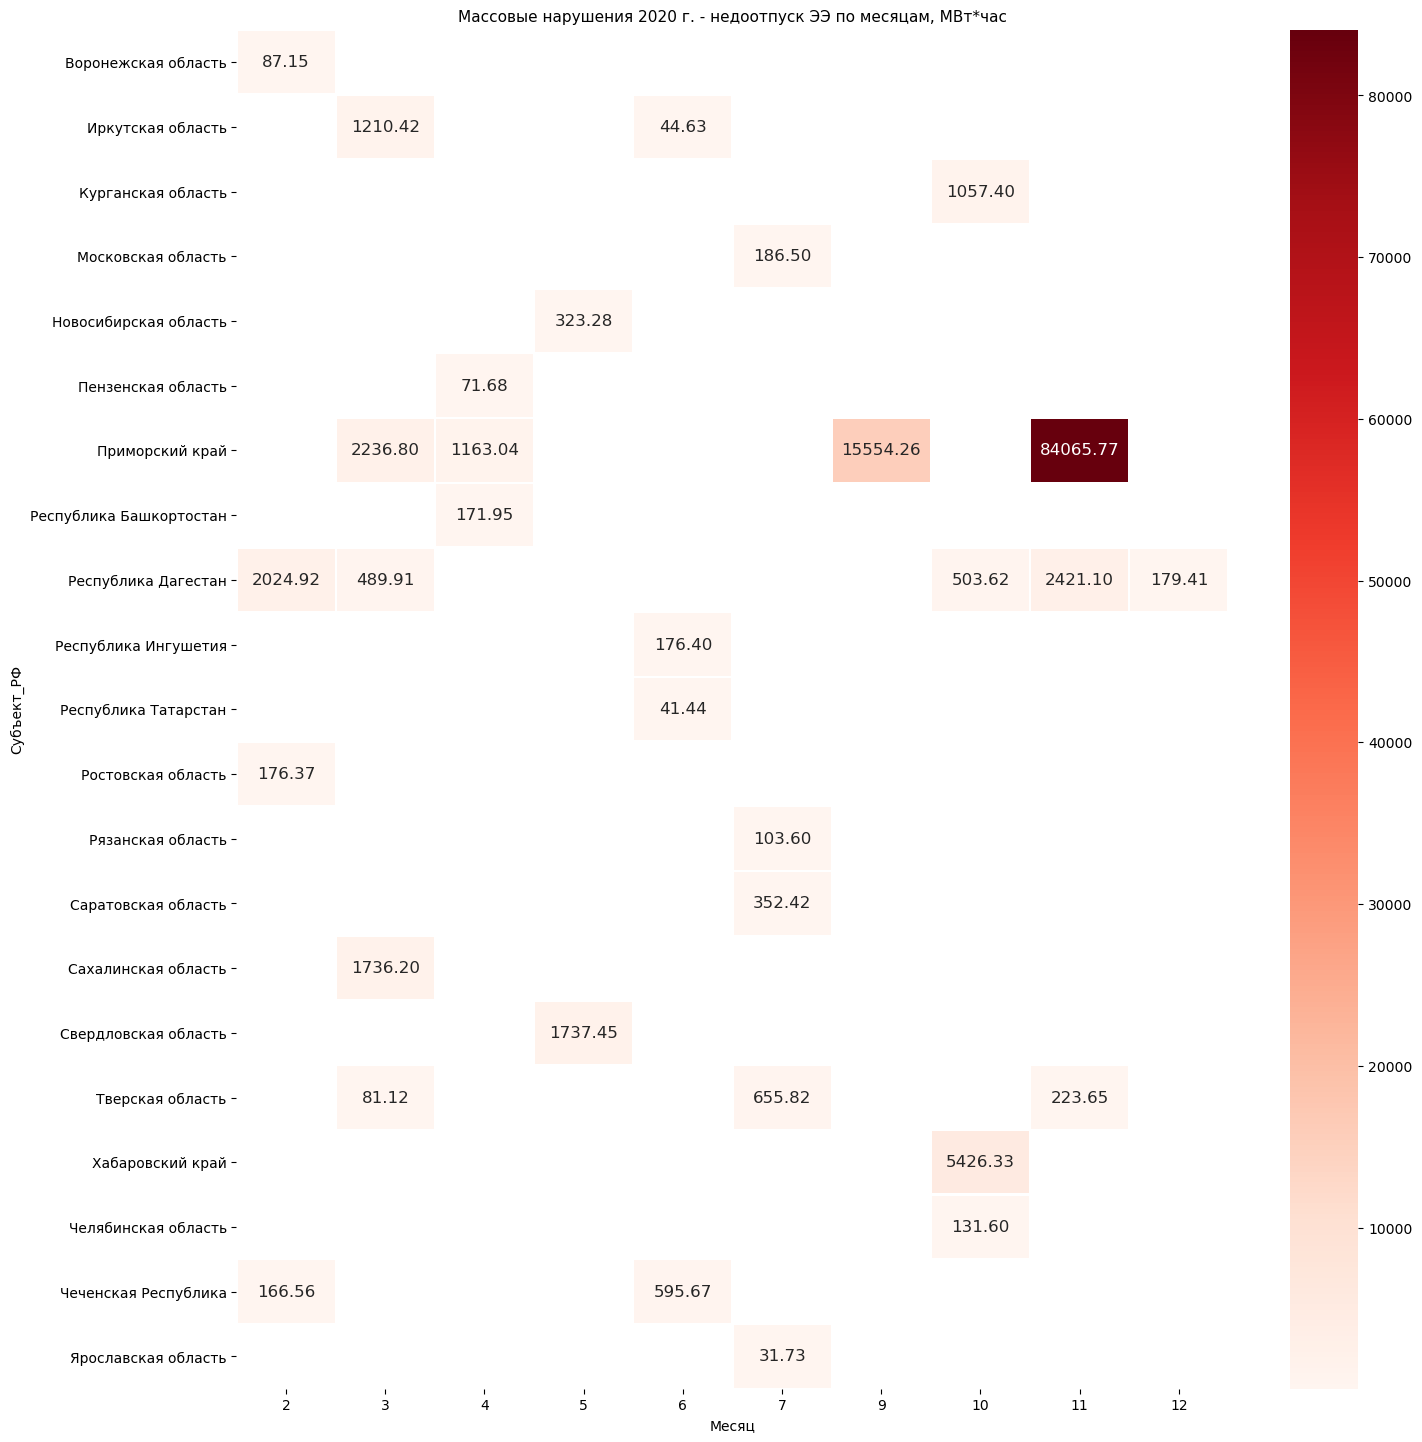

In [37]:
fig_h3 = plt.figure(figsize=(16,18), dpi= 100)
#sns.set(rc={'figure.figsize':(16,56)})

ax_h3 = fig_h3.add_subplot(1, 1, 1)

sns.heatmap(df[df['Год']==2020].pivot_table(
    index='Субъект_РФ', 
    columns='Месяц', 
    values='Недоотпуск', 
    aggfunc='sum'), 
            annot=True, fmt='.2f', annot_kws={'fontsize':12}, cmap='Reds', linewidths=1, ax=ax_h3)



ax_h3.set_title(f'Массовые нарушения 2020 г. - недоотпуск ЭЭ по месяцам, МВт*час',fontsize=11)

# fig_h3.set_figwidth(10)
# fig_h3.set_figheight(25)
#fig_h3.savefig(f'Масс_2020_Недоотпуск_ээ')
plt.show()